# AI Lab Run
V1: New dataset, old model.   
A3: untrain model.   
A5: this time we change the traning target to predicting the phoneme of each frame (which we can grab from the matched phone guide). From this we again check the several matters concerned and evaluate how well it can be guided to learned the phonemes. 

A6: This time we use CTC as prediction loss. 

A7: we do bidirectional LSTM. Bidirectional LSTM using pytorch. (B, L, H) -> (B, L, 2H)

A8: We resume to reconstruction model. But this time bidirectional. Also following the structure of Mockingjoy, not using attention but directly predict the reconstruction based on the BiLSTM result. 

A9: with random masking. 

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
# from torchaudio.models.decoder import ctc_decoder

In [5]:
from model_model import LBiR_LBiRInit as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDatasetRandomMasking as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
# from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [6]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [7]:
BATCH_SIZE = 512

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, 2*INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [8]:
ts = str(get_timestamp())
# ts = "0205143450"
stop_epoch = "29"
train_name = "A_05"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))

train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

A_05-0205210330


0205185813: hiddim = 256. Totally overfitting. Very bad, unlike what Mockingjoy suggests. Dropout = 0.1

0205194558: hiddim = 8. Dropout = 0.5. 

0205204610: with random masking

0205210330: hiddim = 128. Add relu

In [10]:
READ = False
# READ = True

In [11]:
DATAREAD = False

In [13]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)

use_proportion = 0.1

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [14]:
train_num, valid_num, len(train_loader), len(valid_loader)

(77276, 10380, 151, 21)

In [15]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
masked_xx_pad, masked_xx_lens, xx_pad, x_lens = sample_data
print(xx_pad.shape)

torch.Size([512, 73, 64])


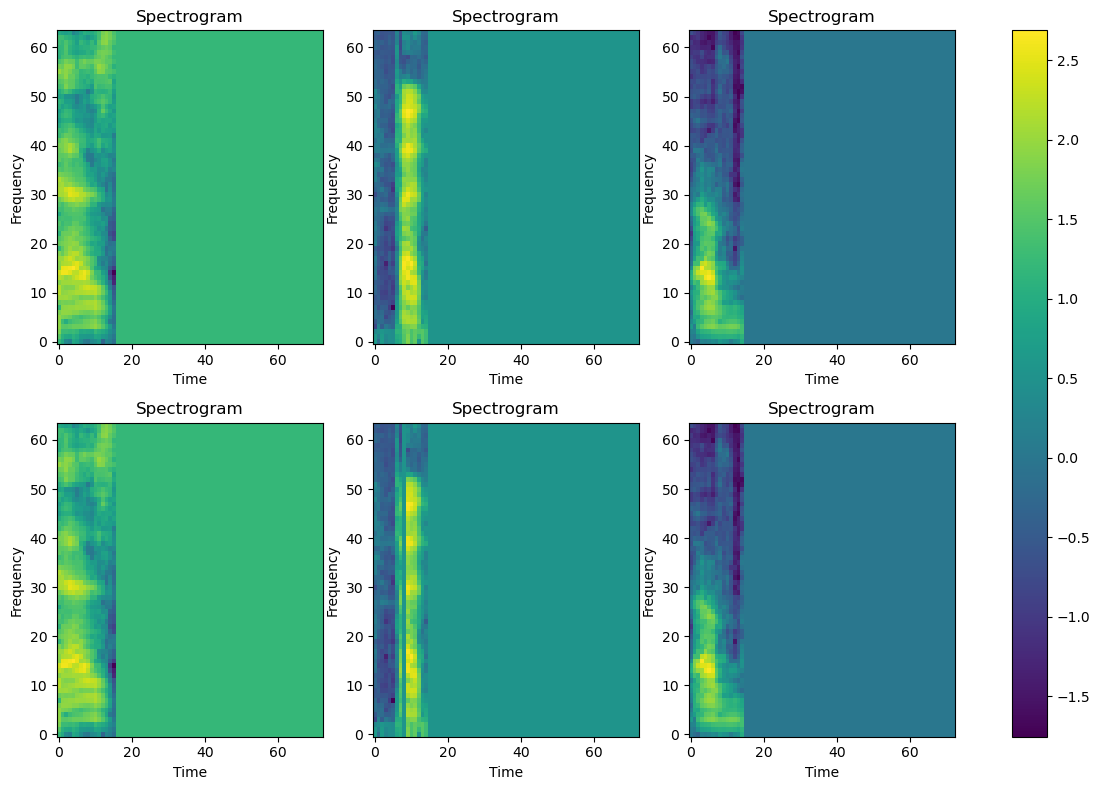

In [16]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 9))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

for i, idx in enumerate(random_indices):
    spectrogram = masked_xx_pad[idx]
    
    ax = axes[i + 3]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Prepare model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_loss = nn.CTCLoss(blank=mymap.encode("BLANK"))
model_loss = MaskedLoss(nn.MSELoss(reduction="none"))

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=3)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [18]:
# initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.LSTM): 
        for name, p in m.named_parameters():
            if "weight" in name: 
                nn.init.orthogonal_(p)
            elif "bias" in name: 
                nn.init.constant_(p, 0)

model.apply(init_weights)

ReconMockingjoyNet(
  (encoder): MockingjoyEncoder(
    (lin_1): Linear(in_features=64, out_features=128, bias=True)
    (rnn): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): MockingjoyDecoder(
    (lin_1): Linear(in_features=256, out_features=256, bias=True)
    (lin_2): Linear(in_features=256, out_features=64, bias=True)
    (act): ReLU()
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [20]:
params

1145792

### Load model if READ

In [21]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [22]:
EPOCHS = 30
BASE = 0

In [23]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens, y, y_lens) in enumerate(train_loader):
            # y_lens should be the same as x_lens
            optimizer.zero_grad()
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(x_hat, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # # 这个函数计算的是全局梯度范数
            # # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # # parameters: an iterable of Variables that will have gradients normalized
            # # max_norm: max norm of the gradients(阈值设定)
            # # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            # pred = model.predict_on_output(x_hat)
            # this_correct, this_total = count_correct(pred, y, x_mask)
            # train_total += this_total
            # train_correct += this_correct

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens, y, y_lens) in enumerate(valid_loader):
            y = x
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(x_hat, y, x_mask)

            valid_loss += loss.item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [24]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  1.971 in Step 0
Training loss  0.228 in Step 100
※※※Training loss  0.363※※※
Valid loss  0.352 in Step 0
※※※Valid loss  0.348※※※
Epoch 1
Training loss  0.191 in Step 0
Training loss  0.158 in Step 100
※※※Training loss  0.166※※※
Valid loss  0.362 in Step 0
※※※Valid loss  0.356※※※
Epoch 2
Training loss  0.149 in Step 0
Training loss  0.140 in Step 100
※※※Training loss  0.142※※※
Valid loss  0.366 in Step 0
※※※Valid loss  0.364※※※
Epoch 3
Training loss  0.135 in Step 0
Training loss  0.129 in Step 100
※※※Training loss  0.131※※※
Valid loss  0.361 in Step 0
※※※Valid loss  0.367※※※
Epoch 4
Training loss  0.128 in Step 0
Training loss  0.125 in Step 100
※※※Training loss  0.124※※※
Valid loss  0.366 in Step 0
※※※Valid loss  0.367※※※
Epoch 5
Training loss  0.122 in Step 0
Training loss  0.120 in Step 100
※※※Training loss  0.120※※※


Exception ignored in: <function _releaseLock at 0x7fa11d08cd60>
Traceback (most recent call last):
  File "/home/franklhtan/anaconda3/envs/wavln/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Valid loss  0.360 in Step 0
※※※Valid loss  0.371※※※
Epoch 6
Training loss  0.121 in Step 0
Training loss  0.118 in Step 100
※※※Training loss  0.117※※※
Valid loss  0.384 in Step 0
※※※Valid loss  0.390※※※
Epoch 7


In [38]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

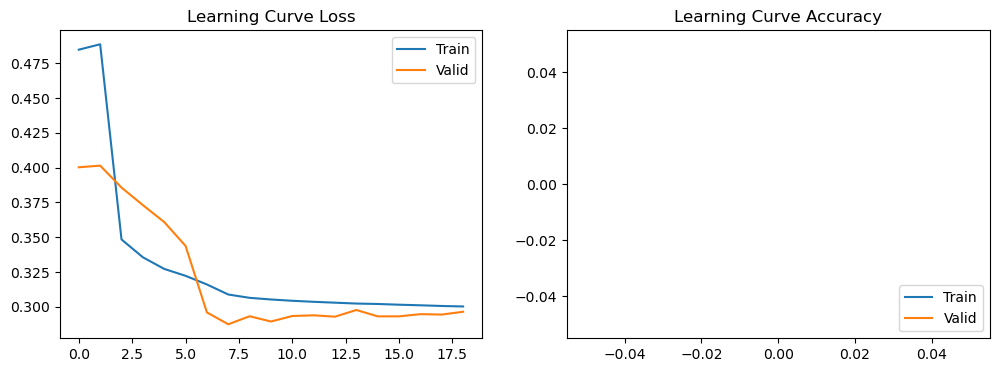

In [39]:
start, end = 0, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot Loss on the left subplot
ax1.plot(train_losses.get()[start:end], label='Train')
ax1.plot(valid_losses.get()[start:end], label='Valid')
ax1.set_title("Learning Curve Loss")
ax1.legend(loc="upper right")

# Plot Accuracy on the right subplot
ax2.plot(train_accs.get()[start:end], label='Train')
ax2.plot(valid_accs.get()[start:end], label='Valid')
ax2.set_title('Learning Curve Accuracy')
ax2.legend(loc="lower right")

## Testing

In [22]:
import torchaudio
from tqdm import tqdm

In [23]:
CTCDecoder = ctc_decoder(
    lexicon=None, 
    tokens=mylist + ["|"], 
    blank_token="BLANK"
)

In [25]:
test_ds = ThisDataset(rec_dir, 
                       test_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "test-phoneseq.gt"))

use_proportion = 0.1

if READ or DATAREAD: 
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))
    use_test_ds = torch.utils.data.Subset(test_ds,test_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(test_ds))
    remain_len = len(test_ds) - use_len
    use_test_ds, remain_ds = random_split(test_ds, [use_len, remain_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "test.use"), use_train_ds.indices)

test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn_yNoPad)
test_num = len(test_loader.dataset)

In [33]:
model.eval()
test_loss = 0.
test_num = len(test_loader)
preds = []
reals = []
for (x, x_lens, y, y_lens) in tqdm(test_loader):
    x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
    
    x = x.to(device)
    # y = y.to(device)
    # y = y.long()

    x_hat = model(x, x_lens, x_mask)

    preds += CTCDecoder(x_hat.cpu())
    reals += y

100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


In [34]:
total_per = 0
total = 0
for real, pred in zip(reals, preds): 
    total_per += torchaudio.functional.edit_distance(real, pred[0].tokens[1:-1]) / len(real)
    total += 1

In [64]:
i = torch.randint(0, total, size=(1, )).item()
print([mymap.decode(x.item()) for x in reals[i]])
print([mymap.decode(x.item()) for x in preds[i][0].tokens[1:-1]])

['M', 'AH', 'S', 'T']
['M', 'S', 'D']


In [35]:
total_per / total

0.7639598337960807

## Conclusion
This model should converge to loss around 0.49x. 